In [2]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import normaltest, skew, kurtosis
from sklearn.metrics import mean_absolute_error, make_scorer, classification_report
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from pymorphy2 import MorphAnalyzer

%matplotlib inline
from matplotlib import pyplot as plt
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

## Содержание

1. Описание набора данных и признаков
2. Первичный анализ данных
3. Первичный визуальный анализ данных
4. Инсайты и закономерности
5. Выбор метрики
6. Выбор модели
7. Предобработка данных
8. Кросс-валидация и настройка гиперпараметров модели
9. Создание новых признаков и описание этого процесса
10. Построение кривых валидации и обучения
11. Прогноз для отложенной выборке
12. Выводы

### 1. Описание набора данных и признаков

#### Задача:


 1. Необходимо реализовать модель на основе предоставленного датасета "АВСОФТ_тест_ML_приложение.csv"
    

### Признаки:

- **repository_name** - имя репозитория
- **commit_hash** - идентификатор коммита
- **commit_date** - дата коммита
- **commit_author** - автор коммита
- **commit_message** - комментарий к коммиту


### Целевая переменная:
 
 `bugs` 

Считаем данные

In [3]:
data = pd.read_csv('АВСОФТ_тест_ML_приложение.csv')

In [4]:
data.head()

,repository_name,commit_hash,commit_date,commit_author,commit_message,bugs
0,mlm,b28abb42,2020-06-12T14:26:12,Victor,объяснения предсказаний с помощью lime,4
1,mlm,438b5c4d,2020-06-12T11:53:10,Victor,Поставил lime вместо eli5,3
2,mlm,8e6e4f31,2020-06-11T15:19:03,Victor,Скрипт для создния пакетов обновления,4
3,mlm,5e0956a6,2020-06-11T10:42:29,Victor,Сортировка весов по убыванию,3
4,mlm,b9f4b40c,2020-06-11T09:25:19,Victor,не надо конвертировать массив до операции по с...,7


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319 entries, 0 to 318
Data columns (total 6 columns):
repository_name    319 non-null object
commit_hash        319 non-null object
commit_date        319 non-null object
commit_author      319 non-null object
commit_message     319 non-null object
bugs               319 non-null int64
dtypes: int64(1), object(5)
memory usage: 15.0+ KB


### 2. Первичный анализ данных

In [6]:
data.describe(include=['object'])

,repository_name,commit_hash,commit_date,commit_author,commit_message
count,319,319,319,319,319
unique,6,319,318,10,309
top,conductor,388b4300,2020-06-10T10:17:03,Victor,Merge branch 'changes-to-merge' into 'master'
freq,114,1,2,134,4


In [7]:
data.describe()

,bugs
count,319.000000
mean,2.996865
std,1.855636
min,0.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,12.000000


У нас один вещественный признак (целевой), остальные - категориальные. Среднее значение количества ошибок - 3. Между верхним квартилем и максимальным значением есть довольно высокая разница, видимо могут присуствовать какие-то выбросы.

### Распределение целевого признака

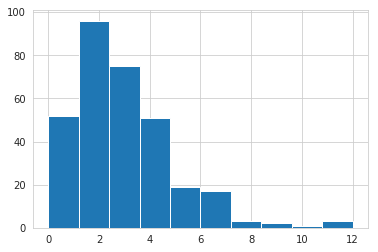

In [8]:
plt.hist(data.bugs);

#### Проверим на нормальность и скошенность

In [9]:
normaltest_result = normaltest(data.bugs)
print(f"Нормальность: {normaltest_result.pvalue}") 

Нормальность: 4.0542457095442116e-27


In [10]:
print(f"Скошенность: {skew(data.bugs)}")

Скошенность: 1.6696652404210477


#### Пропуски

In [11]:
null_content = data.isnull().sum()

In [12]:
null_content

repository_name    0
commit_hash        0
commit_date        0
commit_author      0
commit_message     0
bugs               0
dtype: int64

В нашем датасете нет пропусков, значит можно идти дальше

### 3. Первичный визуальный анализ данных

Оценим влияние наших признаков на количество ошибок. Для этого найдём медиану целевого признака для каждого признака.

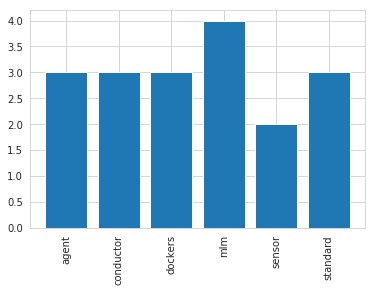

In [13]:
median_targer_for_repository_name = data.groupby(['repository_name']).bugs.median()
plt.xticks(rotation=90)
plt.bar(height = median_targer_for_repository_name, x = median_targer_for_repository_name.index);

В mlm случаются чаще ошибки, но не сказать, чтобы уж прям шибко. В этой категории мы не можем судить о какой-то явной корреляции с количеством ошибок в зависимости от имени репозитория, попробуем посмотреть на другие признаки 

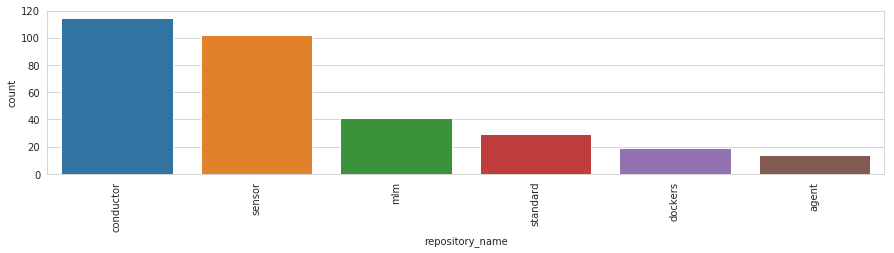

In [14]:
plt.figure(figsize=(15,3))
plt.xticks(rotation=90)
sns.countplot(data=data, x='repository_name', 
              order=data.repository_name.value_counts().index);

Видно, что чаще всего корректируются репозитории с именем `conductor` и `sensor`. Кстати, исходя из двух оценок выше, можно сделать вывод, что правки в репозиторие `sensor` являются более эффективными, чем, в репозитории `conductor`.

Построим диаграмму по количеству правок в зависимости от авторов коммита

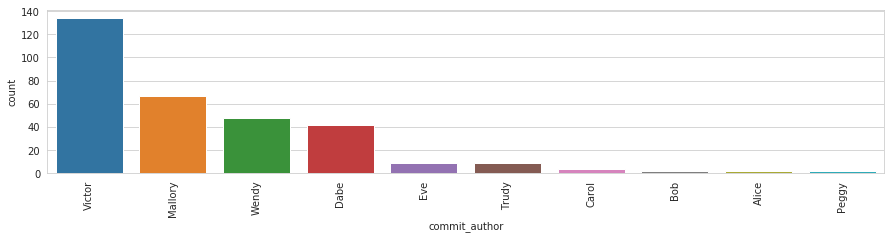

In [15]:
plt.figure(figsize=(15,3))
plt.xticks(rotation=90)
sns.countplot(data=data, x='commit_author', 
              order=data.commit_author.value_counts().index);

Виктор чаще всего вносил правки.

Создадим массив авторов репозиториев, которые осуществляли больше 20 правок и проверим насколько эффективными были эти правки в зависимости от автора 

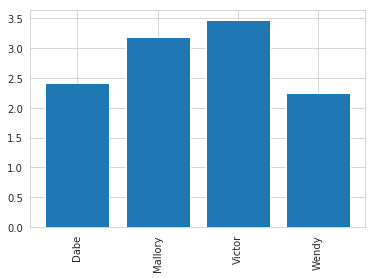

In [16]:
d = ['Victor', 'Mallory', 'Wendy', 'Dabe']
median_targer_for_commit_author = data[data['commit_author'].isin(d)].groupby(['commit_author']).bugs.mean()
plt.xticks(rotation=90)
plt.bar(height = median_targer_for_commit_author, x = median_targer_for_commit_author.index);

На самом деле, мы не можем делать какие-то конкретные выводы по этой метрике, так как, с ростом количества правок растёт и среднее количество багов, а Dabe и Wendy делали меньше правок, чем остальные двое.

### 4. Инсайты и закономерности

Обобщим наши наблюдения:


- чаще всего вносят правки в репозитории с именами `Conductor` и `Sensor`
- в `mlm` чаще всего возникают ошибки
- правки в репозитории `sensor` являются заметно более эффективными по сравнению с остальными
- можно выделить 4-ёх сотрудников, которые чаще всего вносят правки: Victor, Mallory, Dabe, Wendy
- с количеством внесённых правок одним сотрудником растёт и его общее количество ошибок

### 5. Выбор метрики

Для оценки качества модели классификации будет использовать F1 score, как что-то среднее гармоническое между precision и recall.
Хотя ещё попробую взять метрику accuracy.

Для оценки качества регрессионой модели будет использовать коэффициент детерминации $R^2$, потому что нашей главной задачей является способность определения степени разнообразия данных моделью.  

In [17]:
from sklearn.metrics import r2_score, f1_score

### 6. Выбор модели

У нас не так много данных, и, думаю, задача больше стоит предсказать примерное количество ошибок, поэтому решил целевую переменную разделить на классы: если количество ошибок в коммите <= 4 -> 0; <= 8 -> 1; иначе - 2

- Для задачи классификации попробую использовать модель RandomForestClassifier

- Для задачи регрессии будет использовать модель RandomForestRegressor

### 7. Предобработка данных

In [18]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
import spacy

Сортируем наши записи по дате

In [19]:
data.index = data.commit_date
data.sort_index(inplace=True)

In [20]:
data.index = pd.to_datetime(data.commit_date)

Создаём несколько признаков: недели, часы, месяцы. Удаляем признак дата. 

In [21]:
data['weekday'] = data.index.weekday
data['hours'] = data.index.hour

In [22]:
data.index = data.commit_hash
data = data.drop(columns=['commit_hash'])

In [23]:
data.commit_date = pd.to_datetime(data.commit_date)

Кодируем категориальные признаки `repository_name` и `commit_author` с помощью техники One-Hot-Encoding

In [24]:
data = pd.concat([
    data,
    pd.get_dummies(data['repository_name'], prefix = 'repository'),
    pd.get_dummies(data['commit_author'], prefix = 'author')
], axis = 1)
data.drop(
    [
        'repository_name',
        'commit_author',
        'commit_date'
    ],
    axis = 1,
    inplace = True
)

Далее, я обработал признак `commit_message`(лемматизировал, токкенизировал), но работать с ним пока не стал.

In [25]:
data.commit_message = data.commit_message.str.lower()
data.commit_message = data.commit_message.str.replace('[^A-Za-z0-9]+', ' ', regex=True)

Импортируем библаотеку nltk, скачиваем стоп слова

In [26]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/gennadiy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/gennadiy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/gennadiy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [27]:
stopwords = stopwords.words('english')

In [28]:
def stop_words(text):
    return ' '.join(word for word in text.split() if word not in stopwords)

Удаляем стоп слова

In [29]:
data['commit_message'] = data.commit_message.apply(stop_words)

Проводим токкенизацию и лемматизацию текста

In [30]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
def lem_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]
data['lemmatized_tokens'] = data['commit_message'].apply(lem_text)

Категоризируем признак `bugs`

In [31]:
def cat_bugs(num):
    if num <= 4:
        return 0
    elif num <= 8:
        return 1
    return 2

data['cat_bugs'] = data.bugs.apply(cat_bugs)

In [32]:
data.head()

,commit_message,bugs,weekday,hours,repository_agent,repository_conductor,repository_dockers,repository_mlm,repository_sensor,repository_standard,...,author_Carol,author_Dabe,author_Eve,author_Mallory,author_Peggy,author_Trudy,author_Victor,author_Wendy,lemmatized_tokens,cat_bugs
commit_hash,,,,,,,,,,,,,,,,,,,,,
79db41fb,initial commit,3,6,14,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,"[initial, commit]",0
bfa1152f,jsonmaster function separator,6,6,15,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,"[jsonmaster, function, separator]",1
29ba5151,small fixes models py make work,12,6,17,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,"[small, fix, model, py, make, work]",2
a8b55539,added gitignore,3,6,17,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,"[added, gitignore]",0
bb54e4e6,small fixes main py make work,12,6,17,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,"[small, fix, main, py, make, work]",2


### 8. Кросс-валидация и настройка гиперпараметров модели

In [33]:
X = data.drop(columns=['bugs', 'lemmatized_tokens', 'commit_message'], axis=1)

In [34]:
y = data.cat_bugs

In [35]:
X_train, X_holdout, y_train,  y_holdout = train_test_split(X, y, test_size=0.3, random_state=17, shuffle=False)

In [36]:
X_train.shape, X_holdout.shape, y_train.shape,  y_holdout.shape

((223, 19), (96, 19), (223,), (96,))

In [83]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, validation_curve, learning_curve, StratifiedKFold

In [55]:
rfc = RandomForestClassifier(oob_score=True)
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=21)

parametrs = { 'n_estimators': range (4, 26, 2),
              'max_depth': range (5, 21, 5),
              'min_samples_leaf': range (1,8),
              'min_samples_split': range (2,10,2) }

grid = GridSearchCV(rfc, parametrs, cv=skf)
grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=21, shuffle=True),
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=True, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': range(4, 26, 2), 'max_depth': range(5, 21, 5), 'min_samples_leaf': range(1, 8), 'min_samples_split': range(2, 10, 2)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [56]:
grid.best_params_, grid.best_score_

({'max_depth': 10,
  'min_samples_leaf': 1,
  'min_samples_split': 8,
  'n_estimators': 18},
 0.37668161434977576)

In [50]:
predict = grid.predict(X_holdout)
f1_score(y_holdout, predict, average='micro')

0.2604166666666667

Выставив количество естимейторов до 50 я получал переобучение, поэтому пришлось понизить этот параметр. Оценку мы получаем очень плохую, но это ввиду нехватки данных, поэтому будем добавлять признаки.

In [57]:
X = data.drop(columns=['cat_bugs', 'bugs', 'lemmatized_tokens', 'commit_message'], axis=1)
y = data.bugs
X_train, X_holdout, y_train,  y_holdout = train_test_split(X, y, test_size=0.3, random_state=20, shuffle=False)
rf = RandomForestRegressor(oob_score=True)
grid = GridSearchCV(rf, parametrs, cv=skf)
grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=21, shuffle=True),
       error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=True, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': range(4, 26, 2), 'max_depth': range(5, 21, 5), 'min_samples_leaf': range(1, 8), 'min_samples_split': range(2, 10, 2)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [58]:
grid.best_params_, grid.best_score_

({'max_depth': 5,
  'min_samples_leaf': 3,
  'min_samples_split': 6,
  'n_estimators': 10},
 0.2731682966440584)

In [59]:
predict = grid.predict(X_holdout)
r2_score(y_holdout, predict)

0.035835074671147216

Смотрим оценку регрессии, $R^2$ показывает значение близкое к нулю, а значит, наша модель не смогла найти зависимости, влияющие на нашу целевую переменную.

Построим feature_importance

In [60]:
feat_importance = pd.DataFrame(X_train.columns, columns = ['features'])
feat_importance['value'] = grid.best_estimator_.feature_importances_
feat_importance.sort_values('value')[::-1]

,features,value
5,repository_mlm,0.431931
1,hours,0.155932
0,weekday,0.133117
13,author_Mallory,0.088174
6,repository_sensor,0.084328
12,author_Eve,0.042602
16,author_Victor,0.030691
11,author_Dabe,0.010001
3,repository_conductor,0.009590
15,author_Trudy,0.008593


Самым важным признаком, влияющим на целевую переменную является то, для какого репозитория делается коммит.

### 9.Создание новых признаков и описание этого процесса

С помощью библеотеки spacy создадим новые признаки, а именно, количество существительных, количество глаголов в коммитах

In [61]:
nlp = spacy.load("en_core_web_sm")
def pos_verb(text):
    n = 0
    for i in nlp(text):
        if i.pos_ == 'VERB':
            n+=1 
    return n  


def pos_noun(text):
    n = 0
    for i in nlp(text):
        if i.pos_ in ('NOUN', 'PROPN'):
            n+=1 
    return n  

data['num_noun'] = data.commit_message.apply(pos_noun)
data['num_verb'] = data.commit_message.apply(pos_verb)

In [62]:
data['len_commit'] = data.lemmatized_tokens.apply(lambda x: len(x))

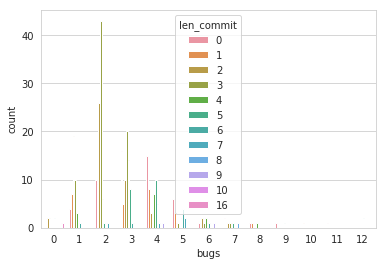

In [63]:
sns.countplot(x='bugs', hue='len_commit', data=data);

In [64]:
data.head()

,commit_message,bugs,weekday,hours,repository_agent,repository_conductor,repository_dockers,repository_mlm,repository_sensor,repository_standard,...,author_Mallory,author_Peggy,author_Trudy,author_Victor,author_Wendy,lemmatized_tokens,cat_bugs,num_noun,num_verb,len_commit
commit_hash,,,,,,,,,,,,,,,,,,,,,
79db41fb,initial commit,3,6,14,0,0,0,1,0,0,...,0,0,0,1,0,"[initial, commit]",0,1,0,2
bfa1152f,jsonmaster function separator,6,6,15,0,0,0,1,0,0,...,0,0,0,1,0,"[jsonmaster, function, separator]",1,3,0,3
29ba5151,small fixes models py make work,12,6,17,0,0,0,1,0,0,...,0,0,0,1,0,"[small, fix, model, py, make, work]",2,4,1,6
a8b55539,added gitignore,3,6,17,0,0,0,1,0,0,...,0,0,0,1,0,"[added, gitignore]",0,0,1,2
bb54e4e6,small fixes main py make work,12,6,17,0,0,0,1,0,0,...,0,0,0,1,0,"[small, fix, main, py, make, work]",2,3,1,6


Исходя из feature_importance я решил удалить признаки, влияют очень слабо на целевой признак

In [85]:
X_2 = data.drop(columns=['cat_bugs', 'bugs', 'lemmatized_tokens', 'commit_message', 'repository_standard',
                        'author_Bob', 'repository_dockers', 'author_Carol', 'repository_agent', 'author_Peggy',
                        'author_Alice', 'author_Trudy', 'author_Wendy'], axis=1)

parametrs = { 'n_estimators': range (10, 51, 10),
              'max_depth': range (1,13, 2),
              'min_samples_leaf': range (1,8),
              'min_samples_split': range (2,10,2) }

y_2 = data.bugs
X_train_2, X_holdout_2, y_train_2,  y_holdout_2 = train_test_split(X_2, y_2, test_size=0.25, random_state=20, shuffle=False)
rf = RandomForestRegressor(oob_score=True)
grid = GridSearchCV(rf, parametrs, cv=skf, scoring = 'r2')
grid.fit(X_train_2, y_train_2)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=21, shuffle=True),
       error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=True, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': range(10, 51, 10), 'max_depth': range(1, 13, 2), 'min_samples_leaf': range(1, 8), 'min_samples_split': range(2, 10, 2)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

In [86]:
grid.best_score_

0.46374051181333437

In [91]:
predict = grid.predict(X_holdout_2)
r2_score(y_holdout_2, predict)

0.04398346080311777

Оценка улучшилась, но не сильно, к сожалению.

### 10. Построение кривых валидации и обучения 

In [92]:
def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2)

<b>Построим кривые валидации</b>, будем менять сложность модели изменяя параметры.

In [105]:
r2_scorer = make_scorer(r2_score)
rf_val = RandomForestRegressor(random_state=17)

Посмотрим на зависимость от числа деревьев.

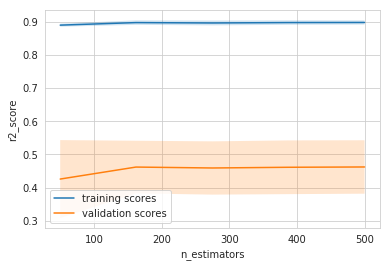

In [103]:
n = np.linspace(50, 500, 5).astype(int)

val_train, val_test = validation_curve(rf_val, X_train_2, y_train_2,
                                       'n_estimators', n, cv=skf,
                                       scoring=r2_scorer, n_jobs=-1)

plot_with_err(n, val_train, label='training scores')
plot_with_err(n, val_test, label='validation scores')
plt.xlabel('n_estimators'); plt.ylabel('r2_score')
plt.legend();

Посмотрим на зависимость от числа объектов в листе.

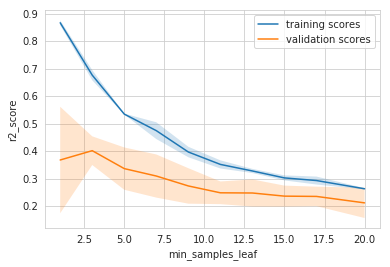

In [106]:
n = np.linspace(1, 20, 10).astype(int)

val_train, val_test = validation_curve(rf_val, X_train_2, y_train_2,
                                       'min_samples_leaf', n, cv=skf,
                                       scoring=r2_scorer, n_jobs=-1)

plot_with_err(n, val_train, label='training scores')
plot_with_err(n, val_test, label='validation scores')
plt.xlabel('min_samples_leaf'); plt.ylabel('r2_score')
plt.legend();

<b>Построим обучающие кривые. </b>

In [108]:
def plot_learning_curve(min_samples_leaf=2, n_estimators=500):
    train_sizes = np.linspace(0.05, 1, 100)
    
    rf_learn = RandomForestRegressor(min_samples_leaf=min_samples_leaf, n_estimators = n_estimators)
    N_train, val_train, val_test = learning_curve(rf_learn, X_train_2, y_train_2, train_sizes=train_sizes, cv=skf,
                                                  scoring=r2_scorer, n_jobs=-1)
    plot_with_err(N_train, val_train, label='training scores')
    plot_with_err(N_train, val_test, label='validation scores')
    plt.xlabel('Training Set Size'); plt.ylabel('r2 score')
    plt.legend()

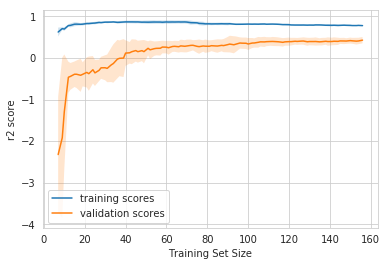

In [109]:
plot_learning_curve()

### 12. Вывод

Можно было обработать текст, построить вектора коммитов, тогда модель, возможно, лучше будет определять класс ошибки. Ещё нужно учитывать тот факт, что 300 записей это совсем немного, и нужно больше данных для построения более качественной модели. 